In [7]:
import numpy as np
import networkx as nx

num_nodes = 4
w = np.array(
    [[0.0, 1.0, 1.0, 0.0], [1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 0.0, 1.0], [0.0, 1.0, 1.0, 0.0]]
)
G = nx.from_numpy_array(w)
print(w)

[[0. 1. 1. 0.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [0. 1. 1. 0.]]


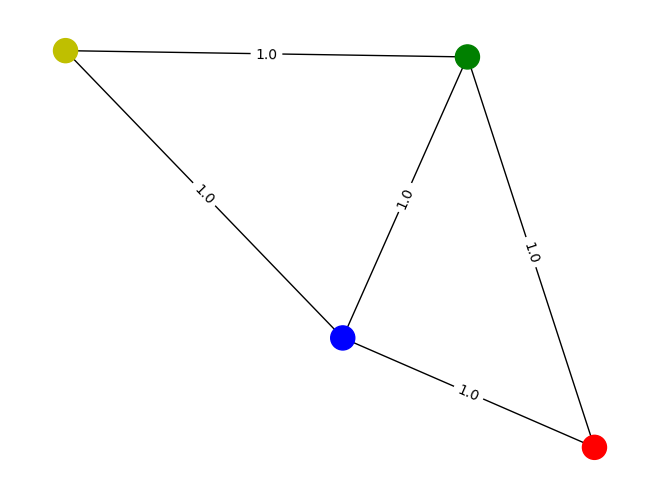

In [ ]:
layout = nx.random_layout(G, seed=10)
colors = ["r", "g", "b", "y"]
nx.draw(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)

In [4]:
def objective_value(x, w):
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        w: Adjacency matrix.
    Returns:
        Value of the cut.
    """
    X = np.outer(x, (1 - x))
    w_01 = np.where(w != 0, 1, 0)
    return np.sum(w_01 * X)


def bitfield(n, L):
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part


# use the brute-force way to generate the oracle
L = num_nodes
max = 2**L
sol = np.inf
for i in range(max):
    cur = bitfield(i, L)

    how_many_nonzero = np.count_nonzero(cur)
    if how_many_nonzero * 2 != L:  # not balanced
        continue

    cur_v = objective_value(np.array(cur), w)
    if cur_v < sol:
        sol = cur_v

print(f"Objective value computed by the brute-force method is {sol}")

Objective value computed by the brute-force method is 3


In [6]:
from qiskit.quantum_info import Pauli, SparsePauliOp


def get_operator(weight_matrix):
    r"""Generate Hamiltonian for the graph partitioning
    Notes:
        Goals:
            1 Separate the vertices into two set of the same size.
            2 Make sure the number of edges between the two set is minimized.
        Hamiltonian:
            H = H_A + H_B
            H_A = sum\_{(i,j)\in E}{(1-ZiZj)/2}
            H_B = (sum_{i}{Zi})^2 = sum_{i}{Zi^2}+sum_{i!=j}{ZiZj}
            H_A is for achieving goal 2 and H_B is for achieving goal 1.
    Args:
        weight_matrix: Adjacency matrix.
    Returns:
        Operator for the Hamiltonian
        A constant shift for the obj function.
    """
    num_nodes = len(weight_matrix)
    pauli_list = []
    coeffs = []
    shift = 0

    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(-0.5)
                shift += 0.5

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(1.0)
            else:
                shift += 1

    return SparsePauliOp(pauli_list, coeffs=coeffs), shift


qubit_op, offset = get_operator(w)
print(qubit_op)
print(offset)

SparsePauliOp(['IIZZ', 'IZIZ', 'IZZI', 'ZIZI', 'ZZII', 'IIZZ', 'IZIZ', 'ZIIZ', 'IIZZ', 'IZZI', 'ZIZI', 'IZIZ', 'IZZI', 'ZZII', 'ZIIZ', 'ZIZI', 'ZZII'],
              coeffs=[-0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,  1. +0.j,  1. +0.j,
  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,  1. +0.j,
  1. +0.j,  1. +0.j,  1. +0.j])
6.5


In [ ]:
from qiskit.primitives import Sampler
from qiskit.quantum_info import Pauli
from qiskit.result import QuasiDistribution

from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA

from qiskit_algorithms.utils import algorithm_globals

sampler = Sampler()


def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """ 
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)


algorithm_globals.random_seed = 10598

optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer, reps=2)

result = qaoa.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f"Objective value computed by QAOA is {objective_value(x, w)}")

C:\Users\shubh\AppData\Local\Temp\ipykernel_13812\1928070479.py:10: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


[1 0 1 0]
Objective value computed by QAOA is 3
